Dylan Hastings

# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.


In [35]:
import requests
import pandas as pd
import numpy as np
from pprint import pprint
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sc
import sklearn
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
import statsmodels.api as sm
import sklearn.feature_extraction.text as text
import gensim
import gensim.downloader as model_api
import re

In [36]:
reviews = []
app_list = [547702041, 284882215, 333903271]
country_list = ['us', 'gb', 'ca']
page_list = [1,2,3,4]

for app in app_list:
    for country in country_list:
        for page in page_list:

            url = f'https://itunes.apple.com/{country}/rss/customerreviews/id={app}/{page}/sortby=mostrecent/json'
            data = requests.get(url).json().get('feed')
            for entry in data.get('entry'):
                this_data = {
                    "rating": entry['im:rating']['label'],
                    "version": entry['im:version']['label'],
                    "title": entry['title']['label'],
                    "content": entry['content']['label'],
                    "country_code": country,
                    "appID": app,
                    "page": page
                }
                reviews.append(this_data)

In [37]:
df = pd.DataFrame(reviews)
df

,rating,version,title,content,country_code,appID,page
0,1,12.3.0,Awful,Give it to facebook to destroy everything they...,us,547702041,1
1,2,12.3.0,Messages,My messages keep deleting😭😭..when I got to loo...,us,547702041,1
2,5,12.3.0,Good! 👍,⭐️⭐️⭐️⭐️⭐️,us,547702041,1
3,1,12.3.0,Bugs,This app is glitchy... it shows unread message...,us,547702041,1
4,1,12.3.0,weak,this application has performed a mindless and ...,us,547702041,1
...,...,...,...,...,...,...,...
1795,3,8.54.5,Twitter review,It’s entertaining. Not always a doom scroll .I...,ca,333903271,4
1796,1,8.54.5,Selling for cheap,"Biased censorship, inferences on democracy",ca,333903271,4
1797,1,8.54.5,Biased Platform,Twitter shows continuously the prejudice they ...,ca,333903271,4
1798,2,8.54.5,Videos will not load.,Can’t watch videos without it freezing. Hit th...,ca,333903271,4


In [38]:
df['rating'] = df.rating.astype(int)

In [39]:
COMPRESSED_SIZE = 5

tf = text.TfidfVectorizer()
X = tf.fit_transform(df['content'])

Xd = X.toarray()
Xd = PCA(COMPRESSED_SIZE).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['rating'].values
print("OLS R^2: ", r2_score(df['rating'], pred))

OLS R^2:  0.07169367135643712


**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.


In [40]:
word_vectors = model_api.load("glove-twitter-100")

In [41]:
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

In [42]:
rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

In [43]:
words = df.content.str.replace(pattern, replacer).str.lower().str.split()

In [44]:
words = pd.DataFrame(words.tolist())
words

,0,1,2,3,4,5,6,7,8,9,...,514,515,516,517,518,519,520,521,522,523
0,give,it,to,facebook,to,destroy,everything,they,get,their,...,None,None,None,None,None,None,None,None,None,None
1,my,messages,keep,deleting😭😭,when,i,got,to,look,at,...,None,None,None,None,None,None,None,None,None,None
2,⭐️⭐️⭐️⭐️⭐️,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,this,app,is,glitchy,it,shows,unread,messages,when,i,...,None,None,None,None,None,None,None,None,None,None
4,this,application,has,performed,a,mindless,and,terrible,job,of,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,it’s,entertaining,not,always,a,doom,scroll,it,can,be,...,None,None,None,None,None,None,None,None,None,None
1796,biased,censorship,inferences,on,democracy,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1797,twitter,shows,continuously,the,prejudice,they,have,against,all,conservatives,...,None,None,None,None,None,None,None,None,None,None
1798,can’t,watch,videos,without,it,freezing,hit,the,play,button,...,None,None,None,None,None,None,None,None,None,None


In [61]:
def soft_get(w):
    try:
        return word_vectors[w]
    except KeyError:
        return np.zeros(word_vectors.vector_size)

def map_vectors(row):
    if np.sum(row.notna()) == 0:
        return np.zeros(word_vectors.vector_size)
    try:
        return np.sum(
            row.loc[row.notna()].apply(soft_get)
        )
    except:
        return np.zeros(word_vectors.vector_size)

emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())
emb

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,4.205269,4.085782,1.248923,1.793175,1.004110,5.418264,1.257753,-4.041674,3.584411,1.262554,...,-5.874520,0.279499,3.642887,-1.608826,2.112607,-2.467857,-1.069858,-5.810354,4.532117,-1.733066
1,1.444885,3.511130,-0.455397,1.524466,0.528605,-0.223851,0.607280,0.150344,1.158095,1.316688,...,-0.437649,1.790969,1.093078,-1.214057,-0.250372,-0.961547,-1.670127,-3.000360,3.414069,0.846515
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4.350170,1.937558,-2.392627,5.387850,0.885408,4.374470,-0.703506,-6.776608,5.656891,0.640466,...,-3.176154,8.579435,2.991770,3.298494,2.573725,-4.127983,3.463827,-6.418324,2.231292,2.737427
4,7.554438,5.148160,6.556507,4.604059,-0.655214,10.026323,-0.809301,-1.454581,-2.449955,-7.117242,...,2.690239,8.262087,3.297184,0.428611,-4.222133,-0.027155,2.937984,-10.299536,12.519457,2.106079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,4.949247,0.512697,2.087320,1.261978,2.721822,7.393965,2.852243,-4.774187,-1.688481,2.063612,...,-1.674055,3.912511,1.178141,-3.151118,-0.703306,-2.991654,-0.281608,-3.609939,0.161707,-2.333173
1796,0.900665,-0.355662,-0.578933,2.011790,0.547352,1.261448,0.005974,-1.154670,1.183386,-1.101772,...,-1.734920,-0.798574,-0.259140,-1.371940,-1.370839,1.087451,1.540970,-1.012830,0.056680,-1.169165
1797,4.865203,-0.581149,-2.964758,1.164165,1.693950,6.569539,0.519650,0.863359,-1.802591,2.890247,...,-7.717455,4.055492,0.352328,0.339768,-5.739942,-1.461772,-0.612924,-7.228075,5.409329,0.720224
1798,4.974205,1.803779,1.595171,-3.638479,1.145357,3.859907,8.210160,-3.216884,3.094817,-3.392413,...,-1.859908,-0.514142,-0.845237,-2.434203,0.852104,-0.692739,2.478424,-2.350481,1.235134,-0.406366


In [62]:
sgdr = SGDRegressor()
sgdr.fit(emb, df.rating)
sgdr.score(emb, df.rating)

-6.786273702723879e+26

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)



In [47]:
Xd = X.toarray()
Xd = PCA(200).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)
pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['rating'].values
pred

array([1.15313281, 1.64603237, 2.05662162, ..., 2.73312219, 1.60310894,
       4.33844095])

In [48]:
print("OLS R^2: ", r2_score(df['rating'], pred))

OLS R^2:  0.637260497767301


In [49]:
from sklearn.metrics import accuracy_score
pred_np = np.array(pred)
pred_round = np.around(pred_np)
accuracy_score(df['rating'], pred_round)

0.4911111111111111

In [27]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(df['rating'],pred_round))

[[  0   0   0   0   0   0   0]
 [128 604 404  28   0   0   0]
 [  0  68 152  28   0   0   0]
 [  0   4  72  48   8   0   0]
 [  0   4  12  20   8   0   0]
 [  0   0  16  32  92  68   4]
 [  0   0   0   0   0   0   0]]


**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.

In [23]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth = 2)
Xd = X.toarray()
Xd = PCA(200).fit(Xd.T).components_.T
clf.fit(Xd, df['rating'])
pred_rf = clf.predict(Xd)
accuracy_score(df['rating'], pred_rf)

0.6466666666666666

In [28]:
print(confusion_matrix(df['rating'],pred_rf))

[[1164    0    0    0    0]
 [ 248    0    0    0    0]
 [ 132    0    0    0    0]
 [  44    0    0    0    0]
 [ 212    0    0    0    0]]


In general, classification models seem to better predict a 5-point rating scale, based on the confusion matrices.  The accuracy score is also higher with the classification model.  The max_depth paramter was set to 2 because higher values tend to result in overfitting the data.

## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result

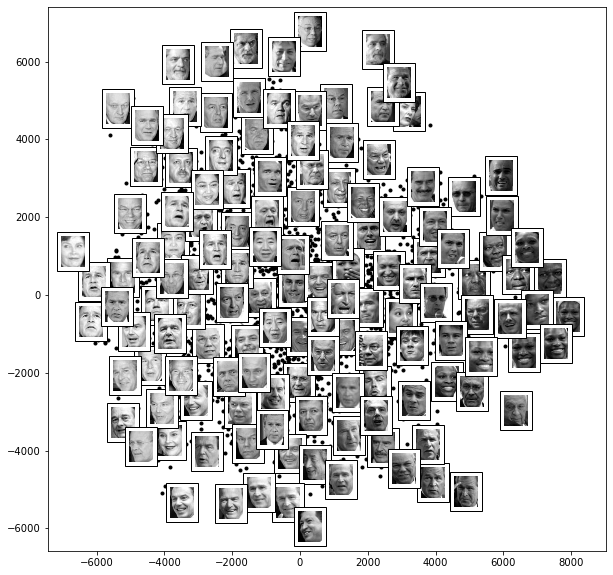

In [71]:
from sklearn.manifold import Isomap
from sklearn.datasets import fetch_lfw_people
import umap

from matplotlib import offsetbox

faces = fetch_lfw_people(min_faces_per_person=30)

def plot_components(faces, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

fig, ax = plt.subplots(figsize=(10, 10))
model = umap.UMAP(n_neighbors=5, n_components=2)
plot_components(faces.data, model=Isomap(n_components=2), images=faces.images[:,::2,::2],
                ax=ax, thumb_frac=0.05)